<a href="https://colab.research.google.com/github/charlesdaigre/project_lewagon_rua/blob/main/PROJECT_HUNGER_GOAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts --quiet

import darts
print(f"Darts version: {darts.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.8 

(749, 2)


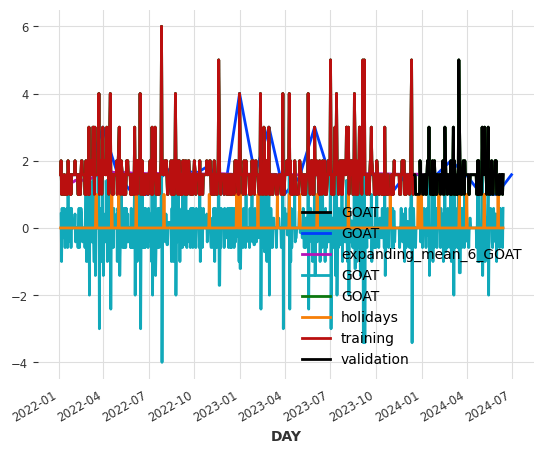

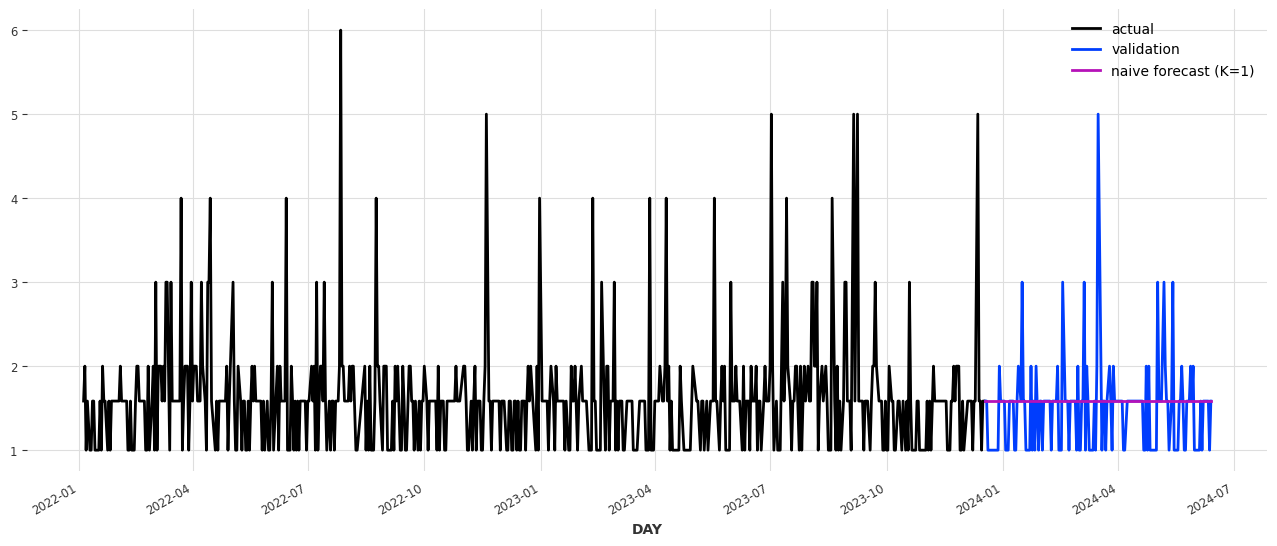

Mean Absolute Percentage Error: 25.97019924381894


In [ ]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models import NaiveSeasonal
from darts.metrics import mape

# Charger le fichier CSV
df = pd.read_csv("/content/Goat_per_day_rua.csv", header=1, names=['DAY', 'GOAT'])
print(df.shape)
df.head()

# Convertir la colonne 'DAY' en type datetime
df['DAY'] = pd.to_datetime(df['DAY'])

# Remplacer les valeurs nulles ou égales à zéro dans la colonne 'GOAT' par la moyenne des valeurs non nulles
df['GOAT'].replace(0, np.nan, inplace=True)
df['GOAT'].fillna(df['GOAT'].mean(), inplace=True)

# Convertir le DataFrame en série temporelle Darts
series = TimeSeries.from_dataframe(df, 'DAY', 'GOAT', fill_missing_dates=True, freq='D')

# Remplir les valeurs manquantes
series = fill_missing_values(series)

# Tracer la série temporelle
series.plot()

# Reéchantillonnage et conversion de fréquence
resampled_example = series.resample("M")
resampled_example.plot()

# Calcul de la moyenne glissante
rolling_mean_example = series.window_transform({"function": "mean", "window": 6})
rolling_mean_example.plot()

# Ingénierie des fonctionnalités
diff_example = series.diff()
diff_example.plot()

hol_example = series.add_holidays("IE")
hol_example.plot()

# Diviser les données en ensembles d'entraînement et de validation
train, val = series.split_before(0.8)
train.plot(label="training")
val.plot(label="validation")

# Modèle NaiveSeasonal
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

# Tracer les résultats
plt.figure(figsize=(16, 6))
train.plot(label="actual")
val.plot(label="validation")
naive_forecast.plot(label="naive forecast (K=1)")
plt.legend()
plt.show()

# Convertir l'index en type datetime avant de créer les séries temporelles
val_df = val.pd_dataframe()
naive_forecast_df = naive_forecast.pd_dataframe()

# S'assurer que les index sont au format datetime
val_df.index = pd.to_datetime(val_df.index)
naive_forecast_df.index = pd.to_datetime(naive_forecast_df.index)

# Filtrer les valeurs nulles ou égales à zéro dans la série réelle
val_positives = val_df[val_df['GOAT'] > 0]
naive_forecast_positives = naive_forecast_df.loc[val_positives.index]

# Créer les séries temporelles Darts à partir des DataFrames filtrés avec fréquence spécifiée
val_positives_ts = TimeSeries.from_times_and_values(val_positives.index, val_positives['GOAT'], fill_missing_dates=True, freq='D')
naive_forecast_positives_ts = TimeSeries.from_times_and_values(naive_forecast_positives.index, naive_forecast_positives['GOAT'], fill_missing_dates=True, freq='D')

# Calculer la MAPE avec la série réelle filtrée
accuracy = mape(val_positives_ts, naive_forecast_positives_ts)

print(f"Mean Absolute Percentage Error: {accuracy}")

In [ ]:
from darts.models import ExponentialSmoothing

# Initialize and fit an Exponential Smoothing model
model = ExponentialSmoothing()
model.fit(train)

# Generate forecasts
exp_forecast = model.predict(len(val))

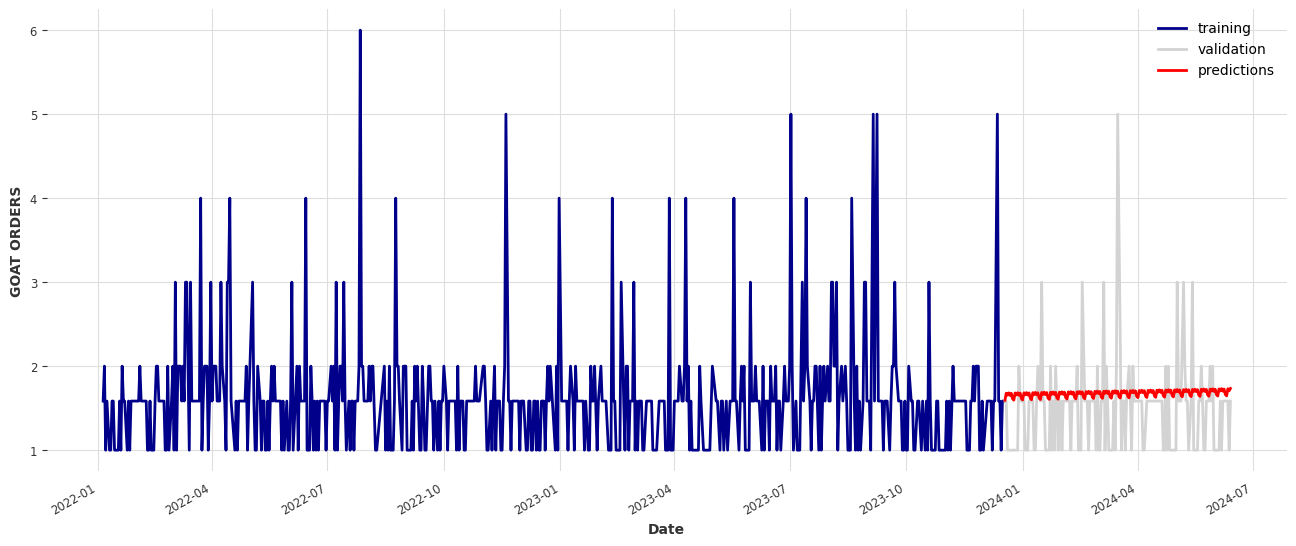

In [ ]:
plt.figure(figsize=(16, 6))

train.plot(label="training", color='darkblue')
val.plot(label="validation", color='lightgrey')
exp_forecast.plot(label="predictions", color='red')
plt.xlabel('Date')  # Légende de l'axe des abscisses
plt.ylabel('GOAT ORDERS')  # Légende de l'axe des ordonnées
plt.legend()
plt.show()

         DAY  GOAT
0 2022-01-05     0
1 2022-01-06     2
2 2022-01-07     1
3 2022-01-08     0
4 2022-01-10     1
DAY     0
GOAT    0
dtype: int64
           DAY      GOAT
749 2024-06-14  0.180010
750 2024-06-15  0.191776
751 2024-06-16  0.218584
752 2024-06-17  0.285791
753 2024-06-18  0.290042
..         ...       ...
834 2024-09-07  0.239718
835 2024-09-08  0.239718
836 2024-09-09  0.239718
837 2024-09-10  0.239718
838 2024-09-11  0.239718

[90 rows x 2 columns]


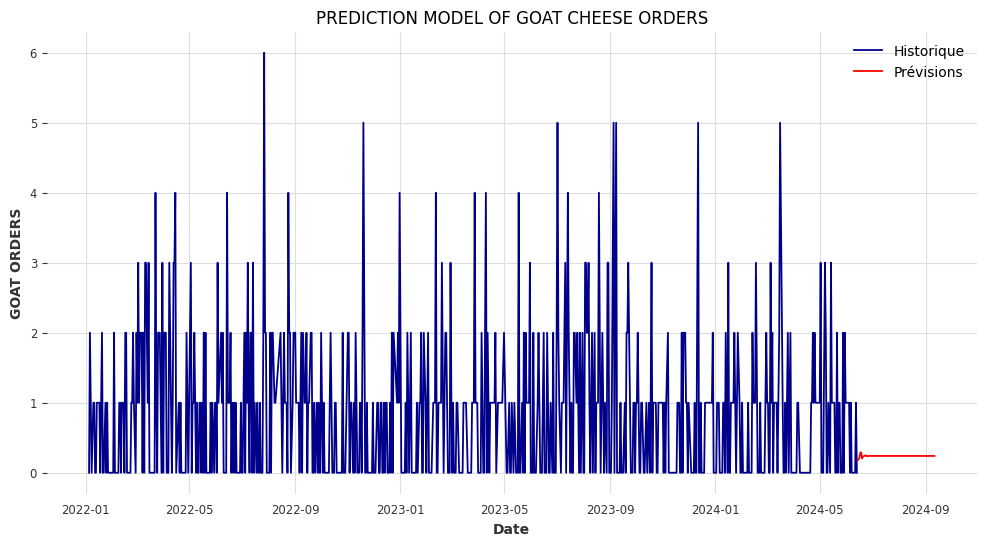

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv('/content/Goat_per_day_rua.csv',header=1, names=['DAY', 'GOAT'])

# Assurez-vous que la colonne DAY est de type datetime
df['DAY'] = pd.to_datetime(df['DAY'])

# Remplacer les valeurs nulles par zéro
df['GOAT'] = df['GOAT'].fillna(0)

# Vérifier les données
print(df.head())
print(df.isna().sum())

# Préparer les données pour ARIMA
y = df['GOAT']

# Définir le modèle ARIMA
model = SARIMAX(y, order=(5,1,0))  # Vous pouvez ajuster les paramètres (p,d,q) selon vos besoins

# Ajuster le modèle
model_fit = model.fit(disp=False)

# Faire des prévisions
forecast_steps = 90  # Prédire les 30 prochains jours
forecast = model_fit.forecast(steps=forecast_steps)

# Ajouter les prévisions au dataframe
forecast_dates = pd.date_range(start=df['DAY'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame({'DAY': forecast_dates, 'GOAT': forecast})

# Afficher les prévisions
print(forecast_df)

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.plot(df['DAY'], df['GOAT'], label='Historique', color='darkblue')
plt.plot(forecast_df['DAY'], forecast_df['GOAT'], label='Prévisions', color='red')
plt.xlabel('Date')
plt.ylabel('GOAT ORDERS')
plt.title('PREDICTION MODEL OF GOAT CHEESE ORDERS')
plt.legend()
plt.show()

        WEEK  GOAT
0 2024-06-17     4
1 2024-06-24     9
2 2024-07-01     5
3 2024-07-08    13
4 2024-07-15     5
5 2024-07-22     6
6 2024-07-29    12
7 2024-08-05     6
8 2024-08-12     9
9 2024-08-19     5


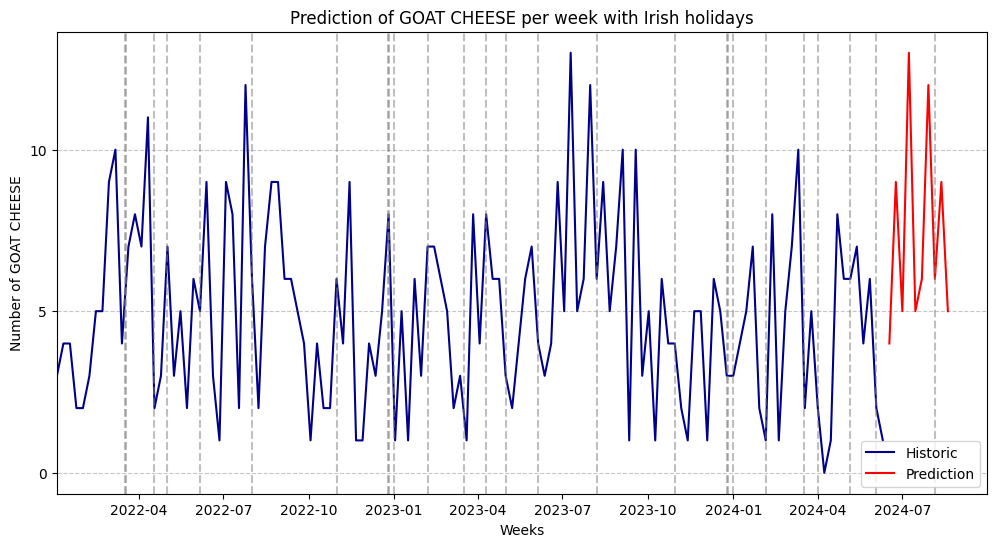

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays

# Charger les données
df = pd.read_csv("/content/Goat_per_day_rua.csv", header=1, names=['DAY', 'GOAT'])

# Assurez-vous que la colonne DAY est de type datetime
df['DAY'] = pd.to_datetime(df['DAY'], errors='coerce')

# Vérifiez s'il y a des valeurs non converties en datetime
if df['DAY'].isna().any():
    print("Certaines dates n'ont pas pu être converties. Vérifiez le format des dates dans votre fichier CSV.")
    print(df[df['DAY'].isna()])

# Remplacer les valeurs nulles par zéro
df['GOAT'] = df['GOAT'].fillna(0)

# Regrouper les données par semaine
df['WEEK'] = df['DAY'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_data = df.groupby('WEEK')['GOAT'].sum().reset_index()

# Préparer les données
y = weekly_data['GOAT']

# Modèle NaiveSeasonal
# Utiliser une saisonnalité annuelle (52 semaines)
season_length = 52

# Vérifier la longueur de la série
if len(y) < season_length:
    raise ValueError(f"La longueur de la série ({len(y)}) est inférieure à la longueur de la saison ({season_length}).")

# Créer une fonction de prédiction NaiveSeasonal
def naive_seasonal_forecast(series, forecast_steps, season_length):
    forecast = []
    for i in range(forecast_steps):
        forecast.append(series.iloc[-season_length + (i % season_length)])
    return forecast

# Faire des prévisions
forecast_steps = 10  # Prédire les 10 prochaines semaines
forecast = naive_seasonal_forecast(y, forecast_steps, season_length)

# Ajouter les prévisions au dataframe
last_date = weekly_data['WEEK'].iloc[-1]
forecast_dates = [last_date + pd.Timedelta(weeks=i+1) for i in range(forecast_steps)]
forecast_df = pd.DataFrame({'WEEK': forecast_dates, 'GOAT': forecast})

# Afficher les prévisions
print(forecast_df)

# Récupérer les jours fériés en Irlande
irish_holidays = holidays.Ireland(years=[2022, 2023, 2024])

# Convertir les jours fériés en une liste de dates
holiday_dates = pd.to_datetime(list(irish_holidays.keys()))

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['WEEK'], weekly_data['GOAT'], label='Historic', color='darkblue')
plt.plot(forecast_df['WEEK'], forecast_df['GOAT'], label='Prediction', color='red')

# Marquer les jours fériés sur le graphique
for holiday in holiday_dates:
    plt.axvline(x=holiday, color='grey', linestyle='--', alpha=0.5)

# Définir la limite de l'axe x pour s'arrêter à octobre 2024
plt.xlim(weekly_data['WEEK'].min(), pd.Timestamp('2024-09-30'))

# Ajouter des lignes horizontales pointillées à intervalles réguliers
plt.grid(axis='y', linestyle='--', which='both', alpha=0.7)

# Ajuster les positions des ticks sur l'axe y
plt.yticks(np.arange(0, max(y) + 1, 5))

plt.xlabel('Weeks')
plt.ylabel('Number of GOAT CHEESE')
plt.title('Prediction of GOAT CHEESE per week with Irish holidays')
plt.legend()
plt.show()

# Optionnel: Calculer l'erreur quadratique moyenne (si vous avez des données de test)
# from sklearn.metrics import mean_squared_error
# y_true = y[-forecast_steps:]  # Supposons que vous avez les vraies valeurs pour les dernières semaines
# mse = mean_squared_error(y_true, forecast)
# print(f'Erreur quadratique moyenne: {mse}')